# Column Generation for VRP

Ref. https://www.brainpad.co.jp/doors/contents/01_tech_2020-10-23-000003/

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

In [48]:
# Problem parameters
num_customers = 10

coordinates_depot = np.array([0.5, 0.5])
coordinates_customers = np.random.rand(num_customers, 2)
coordinates = np.vstack((coordinates_depot, coordinates_customers))

weights = np.random.randint(5, 15, num_customers)

vehicle_capacity = 40

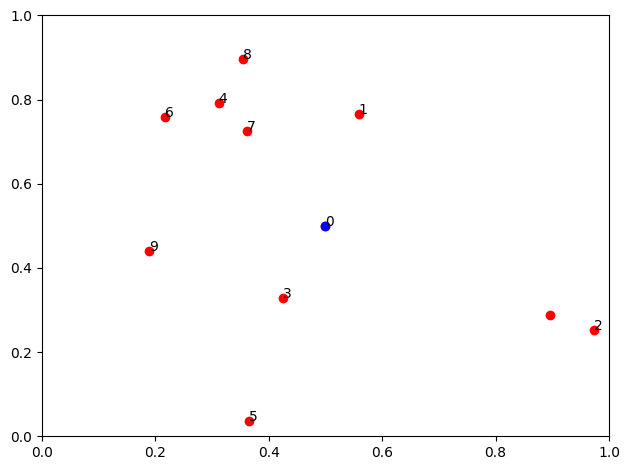

In [49]:
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='r')
plt.scatter(coordinates_depot[0], coordinates_depot[1], c='b')
for i in range(num_customers):
    plt.annotate(i, (coordinates[i, 0], coordinates[i, 1]))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [50]:
# calculate costs
costs = np.zeros((num_customers + 1, num_customers + 1))
for i in range(num_customers + 1):
    for j in range(num_customers + 1):
        if i == j:
            continue
        costs[i, j] = np.linalg.norm(coordinates[i] - coordinates[j])
        costs[j, i] = costs[i, j]

In [51]:
def create_init_routes() -> list[tuple[int]]:
    # Create a route for each customer
    return [(0, i, 0) for i in range(1, num_customers + 1)]

In [52]:
def calculate_route_cost(route: tuple[int]) -> float:
    return sum(costs[route[i], route[i + 1]] for i in range(len(route) - 1))

In [53]:
def solve_dual_problem(routes: list[tuple[int]], route_costs: dict[tuple[int], float]) -> list[float]:
    problem = pulp.LpProblem("DualProblem", pulp.LpMaximize)

    # Variables
    y = pulp.LpVariable.dicts("y", range(num_customers), lowBound=0, cat=pulp.LpContinuous)

    # Objective function
    problem += pulp.lpSum([y[i] for i in range(num_customers)])

    # Constraints
    for route in routes:
        problem += pulp.lpSum([y[i - 1] for i in route[1:-1]]) <= route_costs[route]

    status = problem.solve(pulp.PULP_CBC_CMD(msg=0, timeLimit=60, threads=8))
    if status != 1:
        raise Exception("Dual problem not solved")

    return [0] + [y[i].varValue for i in range(num_customers)]

In [54]:
def solve_pricing_problem(benefits: list[float], big_M: int = 100) -> tuple[int]:
    problem = pulp.LpProblem("PricingProblem", pulp.LpMinimize)

    # Variables
    z = pulp.LpVariable.dicts(
        "z",
        ((i, j) for i in range(num_customers + 1) for j in range(num_customers + 1)),
        lowBound=0,
        upBound=1,
        cat=pulp.LpInteger
    )

    u = pulp.LpVariable.dicts("u", range(num_customers), lowBound=0, upBound=num_customers, cat=pulp.LpInteger)

    # Objective function
    problem += pulp.lpSum([(costs[i][j] - benefits[j]) * z[i, j] for i in range(num_customers + 1) for j in range(num_customers + 1) if i != j])

    # Constraints
    problem += pulp.lpSum([z[0, j] for j in range(1, num_customers + 1)]) == 1
    problem += pulp.lpSum([z[i, 0] for i in range(1, num_customers + 1)]) == 1

    for i in range(1, num_customers + 1):
        problem += pulp.lpSum([z[i, j] for j in range(num_customers + 1)]) <= 1

    for j in range(1, num_customers + 1):
        problem += pulp.lpSum([z[i, j] for i in range(num_customers + 1)]) <= 1

    for i in range(1, num_customers + 1):
        problem += pulp.lpSum([z[i, j] for j in range(num_customers + 1) if i != j]) == pulp.lpSum([z[j, i] for j in range(num_customers + 1) if i != j])

    for i in range(1, num_customers + 1):
        for j in range(1, num_customers + 1):
            problem += u[i - 1] + num_customers * (1 - z[i, j]) <= u[j - 1]

    problem += pulp.lpSum([weights[j - 1] * z[i, j] for i in range(num_customers + 1) for j in range(1, num_customers + 1) if i != j]) <= vehicle_capacity

    status = problem.solve(pulp.PULP_CBC_CMD(msg=0, timeLimit=60, threads=8))

    if status != 1:
        raise Exception("Pricing problem not solved")

    routes = [0]
    while True:
        for j in range(num_customers + 1):
            if z[routes[-1], j].varValue == 1:
                routes.append(j)
                break
        if routes[-1] == 0:
            break

    return tuple(routes)

In [55]:
def solve_master_problem(routes: list[tuple[int]], route_costs: dict[tuple[int], float]) -> tuple[list[tuple[int]], float]:
    problem = pulp.LpProblem("MasterProblem", pulp.LpMinimize)

    num_routes = len(routes)

    # Variables
    x = pulp.LpVariable.dicts("x", range(num_routes), lowBound=0, upBound=1, cat=pulp.LpInteger)

    # Objective function
    problem += pulp.lpSum([route_costs[route] * x[r] for r, route in enumerate(routes)])

    # Constraints
    for i in range(1, num_customers + 1):
        problem += pulp.lpSum([x[r] for r, route in enumerate(routes) if i in route]) == 1

    status = problem.solve(pulp.PULP_CBC_CMD(msg=0, timeLimit=60, threads=8))
    if status != 1:
        raise Exception("Master problem not solved")

    routes_selected = [routes[r] for r in range(num_routes) if x[r].varValue == 1]
    objective_value = pulp.value(problem.objective)
    return routes_selected, objective_value

In [56]:
max_iterations = 500

routes_hist = []
objective_values_hist = []
diff_hist = []

routes = create_init_routes()
route_costs = {route: calculate_route_cost(route) for route in routes}

selected_routes, objective_value = solve_master_problem(routes, route_costs)
objective_values_hist.append(objective_value)
print(f"Initial routes: {selected_routes} with objective value {objective_value}")

for t in range(max_iterations):
    print(f"Iteration {t}")
    benefits = solve_dual_problem(routes, route_costs)
    route_next = solve_pricing_problem(benefits)

    route_cost_next = calculate_route_cost(route_next)
    route_costs[route_next] = route_cost_next

    diff = route_cost_next - sum(benefits[i] for i in route_next)
    diff_hist.append(diff)
    print(f"difference: {diff}")

    if abs(diff) <= 1e-6:
        print("Finished!!!")
        break

    routes.append(route_next)
    routes_hist.append(routes)
    print(f"Route added: {route_next} with cost {route_cost_next}")

    # Solve the master problem
    selected_routes, objective_value = solve_master_problem(routes, route_costs)
    objective_values_hist.append(objective_value)
    print(f"Currnet routes: {selected_routes} with objective value {objective_value}")

# Solve the master problem
selected_routes, objective_value = solve_master_problem(routes, route_costs)
objective_values_hist.append(objective_value)
print(f"Selected routes: {selected_routes} with objective value {objective_value}")

Initial routes: [(0, 1, 0), (0, 2, 0), (0, 3, 0), (0, 4, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (0, 8, 0), (0, 9, 0), (0, 10, 0)] with objective value 7.319097017790974
Iteration 0
difference: -2.1555108729741654
Route added: (0, 4, 8, 1, 2, 10, 0) with cost 1.8969801670258342
Currnet routes: [(0, 3, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (0, 9, 0), (0, 4, 8, 1, 2, 10, 0)] with objective value 5.163586104037494
Iteration 1
difference: -1.4247160143311586
Route added: (0, 2, 5, 9, 6, 1, 0) with cost 2.5546680256688417
Currnet routes: [(0, 3, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (0, 9, 0), (0, 4, 8, 1, 2, 10, 0)] with objective value 5.163586104037494
Iteration 2
difference: -1.6657925620295282
Route added: (0, 8, 4, 6, 9, 0) with cost 1.268314407970472
Currnet routes: [(0, 3, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (0, 9, 0), (0, 4, 8, 1, 2, 10, 0)] with objective value 5.163586104037494
Iteration 3
difference: -1.2332135484064335
Route added: (0, 10, 2, 5, 3, 0) with cost 1.6664960515935665
C

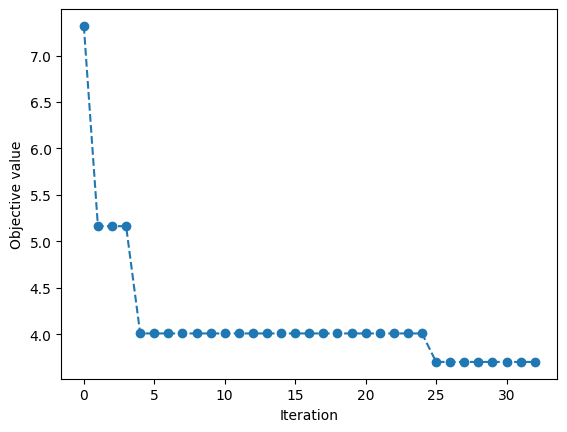

In [57]:
plt.plot(objective_values_hist, 'o--')
plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.show()

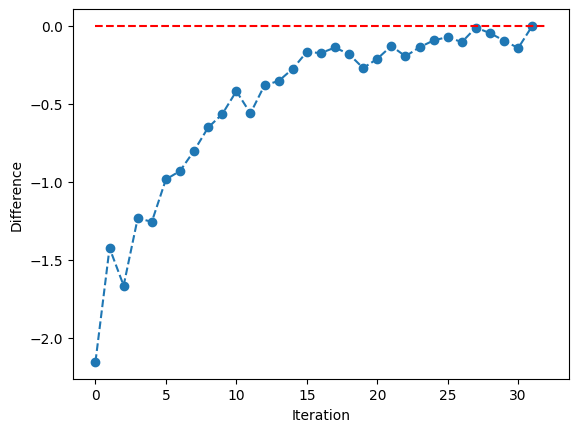

In [58]:
plt.plot(diff_hist, 'o--')
plt.hlines(0, 0, len(diff_hist), colors='r', linestyles='dashed')

plt.xlabel("Iteration")
plt.ylabel("Difference")
plt.show()

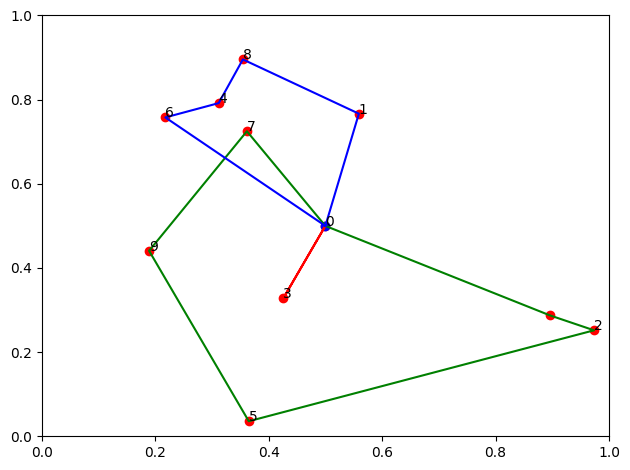

In [59]:
# show the selected routes
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='r')
plt.scatter(coordinates_depot[0], coordinates_depot[1], c='b')

for i in range(num_customers):
    plt.annotate(i, (coordinates[i, 0], coordinates[i, 1]))

colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]

for r, route in enumerate(selected_routes):
    plt.plot(
        [coordinates[i, 0] for i in route],
        [coordinates[i, 1] for i in route],
        c=colorlist[r % len(colorlist)]
    )

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()